# XHEC: Session 6-2  

Explore topic extraction and sentiment analysis existing libraries 

## Import libraries 

In [1]:
#!git clone https://github.com/rwalk/gsdmm
#pip install transformers==2.4.1
#pip install flair

In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import gensim
import gensim.corpora as corpor
import pyLDAvis.gensim
import pyLDAvis
from gsdmm.gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
import operator
from tqdm import tqdm_notebook as tqdm
import flair
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
nltk.download('vader_lexicon')
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-03-11 21:27:52,800 loading file /Users/Abderrahmane/.flair/models/imdb-v0.4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Abderrahmane/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data 

In [5]:
document = pickle.load(open('comments_subsample.pkl', "rb" ))

In [6]:
document.head()

,id_resto,id_comment,resto,rating,title,diner_date,rating_date,other_ratings_category,other_ratings_value,content,clean_content
0,g528819-d10162972,g528819-d10162972-r738854398,Stella_s_Portuguese_Cafe_and_Restaurant,5,AMAZING!!! Can’t recommend it enough.,December 2019,2020-01-13,"[Value, Service, Food]","[50, 50, 50]",The service and food is amazing. This is defin...,"[amaz, definit, hidden, gem, everyth, cook, sc..."
1,g186338-d1059621,g186338-d1059621-r738889879,Orsini_Ristorante,4,Convenient position,December 2019,2020-01-13,[],[],Conveniently placed for the V and A and not to...,"[conveni, place, far, royal, albert, hall, ext..."
2,g2280590-d12084587,g2280590-d12084587-r738886825,The_City_Arms,2,Expensive,January 2020,2020-01-13,"[Value, Service, Food]","[20, 20, 30]",As this a just a pub and not a restaurant you ...,"[pub, would, expect, pub, price, price, expens..."
3,g186338-d2441081,g186338-d2441081-r738902402,The_Vincent_Rooms_Brasserie_The_Escoffier_Room,5,Outstanding!,January 2020,2020-01-13,"[Value, Service, Food]","[50, 50, 50]","Wonderful food, service and hospitality. Havin...","[wonder, hospit, eaten, sever, time, brasseri,..."
4,g186338-d17728520,g186338-d17728520-r738955011,Hard_Rock_Cafe_Piccadilly_Circus,5,Lovely time spent in HRC PC,January 2020,2020-01-13,[],[],"Beautiful evening, lovely food and great beer ...","[beauti, even, love, beer, host, fabio, take, ..."


## Topic extraction 

### LDA with gensim 

In [7]:
#Dictionary
tokens = document.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [6]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [7]:
for i,topic in ldaModel.show_topics(formatted=True, num_topics=10, num_words=20):
    print(str(i)+": "+ topic+"\n")

0: 0.020*"love" + 0.019*"birthday" + 0.018*"sunday" + 0.016*"lunch" + 0.014*"excel" + 0.013*"meal" + 0.013*"staff" + 0.013*"even" + 0.012*"dinner" + 0.012*"roast" + 0.012*"wonder" + 0.009*"celebr" + 0.008*"thank" + 0.008*"famili" + 0.008*"enjoy" + 0.008*"parti" + 0.007*"delici" + 0.007*"perfect" + 0.007*"special" + 0.007*"atmospher"

1: 0.023*"pub" + 0.015*"chicken" + 0.014*"dish" + 0.013*"nice" + 0.008*"order" + 0.008*"beer" + 0.008*"tast" + 0.007*"menu" + 0.007*"meat" + 0.007*"lamb" + 0.007*"starter" + 0.007*"love" + 0.007*"curri" + 0.006*"thai" + 0.006*"tasti" + 0.006*"also" + 0.006*"place" + 0.006*"tri" + 0.006*"portion" + 0.006*"main"

2: 0.027*"love" + 0.026*"staff" + 0.022*"friendli" + 0.022*"amaz" + 0.022*"recommend" + 0.016*"atmospher" + 0.016*"place" + 0.013*"visit" + 0.013*"realli" + 0.013*"excel" + 0.013*"delici" + 0.012*"definit" + 0.012*"fantast" + 0.011*"nice" + 0.011*"friend" + 0.010*"back" + 0.009*"would" + 0.009*"highli" + 0.009*"help" + 0.008*"us"

3: 0.028*"breakfas

In [8]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

0.4608692484281316

In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.172226 -0.073899       1        1  20.684721
8     -0.010046 -0.027940       2        1  14.482493
2      0.136042 -0.049114       3        1  14.184506
1     -0.025159  0.066903       4        1  10.116423
7     -0.059756 -0.015210       5        1   9.127209
9      0.136144  0.043584       6        1   8.108189
0      0.137964 -0.091720       7        1   7.558653
5     -0.108885 -0.081991       8        1   6.184236
3      0.002181  0.014519       9        1   5.772043
6     -0.036260  0.214868      10        1   3.781528, topic_info=           Term         Freq        Total Category  logprob  loglift
1          amaz  5096.000000  5096.000000  Default  30.0000  30.0000
183        fish  1616.000000  1616.000000  Default  29.0000  29.0000
1266  breakfast  1555.000000  1555.000000  Default  28.0000  28.0000
52          pub  2699.000000  2699.000000  Default  27.0000  27.0000
638         tea  1369.000000  1369.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
344       excel   235.809372  5734.394531  Topic10  -4.9470   0.0838
383       order   226.900528  4528.593262  Topic10  -4.9855   0.2814
77         time   229.022018  6400.618164  Topic10  -4.9762  -0.0553
223       steak   194.980301  2078.954590  Topic10  -5.1371   0.9083
39        place   188.327652  7482.760254  Topic10  -5.1718  -0.4071

[834 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
104       1  0.096971   absolut
104       2  0.067324   absolut
104       3  0.473120   absolut
104       4  0.045088   absolut
104       5  0.035206   absolut
...     ...       ...       ...
4292      2  0.027078  yorkshir
4292      4  0.108311  yorkshir
4292      7  0.848440  yorkshir
4758      7  0.982452      youv
7317      7  0.988390      zaza

[2951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 2, 8, 10, 1, 6, 4, 7])

In [11]:
#with open(f'model/lda_model.pkl', 'wb') as f:
#    pickle.dump(ldaModel, f)
#    f.close()

### GSDMM 

In [12]:
document['nb_token'] = list(map(len, document['clean_content']))
docs = document.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

In [13]:
nb_topic = 10
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

# Save model
#with open(f'model/gsdmm_model.pkl', 'wb') as f:
#    pickle.dump(mgpModel, f)
#    f.close()

/Users/lysophie/OneDrive - Capgemini/Desktop/Projet/XHEC/gsdmm/gsdmm/mgp.py:100: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, doc in tqdm(enumerate(docs)):


/Users/lysophie/OneDrive - Capgemini/Desktop/Projet/XHEC/gsdmm/gsdmm/mgp.py:113: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _iter in tqdm(range(n_iters)):


In stage 0: transferred 24991 clusters with 10 clusters populated
In stage 1: transferred 15102 clusters with 10 clusters populated
In stage 2: transferred 8470 clusters with 10 clusters populated
In stage 3: transferred 6174 clusters with 10 clusters populated
In stage 4: transferred 4836 clusters with 10 clusters populated
In stage 5: transferred 4317 clusters with 10 clusters populated
In stage 6: transferred 3972 clusters with 10 clusters populated
In stage 7: transferred 3892 clusters with 10 clusters populated
In stage 8: transferred 3620 clusters with 10 clusters populated
In stage 9: transferred 3432 clusters with 10 clusters populated
In stage 10: transferred 3289 clusters with 10 clusters populated
In stage 11: transferred 3251 clusters with 10 clusters populated
In stage 12: transferred 3146 clusters with 10 clusters populated
In stage 13: transferred 3273 clusters with 10 clusters populated
In stage 14: transferred 3206 clusters with 10 clusters populated
In stage 15: trans

In [14]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

In [36]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [1574 3277 2113 2918 2677 3497 3143 2915 2603 5280]
********************
Most important clusters (by number of docs inside): [9 5 1 6 3 7 4 8 2 0]
********************
Cluster 9 : [('tabl', 2822), ('us', 2417), ('order', 2410), ('staff', 2054), ('time', 1992), ('wait', 1687), ('ask', 1645), ('one', 1614), ('would', 1544), ('arriv', 1411), ('even', 1377), ('place', 1367), ('drink', 1352), ('go', 1337), ('book', 1331), ('meal', 1237), ('get', 1190), ('disappoint', 1096), ('menu', 1093), ('back', 1079), ('came', 1071), ('visit', 1070), ('bar', 1062), ('manag', 1045), ('like', 1020), ('realli', 1010), ('minut', 1002), ('experi', 958), ('didnt', 952), ('went', 923)]
********************
Cluster 5 : [('love', 984), ('staff', 967), ('bar', 903), ('excel', 898), ('visit', 833), ('meal', 775), ('lunch', 775), ('place', 770), ('brasseri', 692), ('menu', 672), ('friendli', 668), ('nice', 640), ('steak', 635), ('dinner', 627), ('time', 626), ('atmospher', 607), ('us

### pyLDAvis with gsdmm

In [16]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [17]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [18]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [19]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [20]:
def deleteNonPorcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [22]:
probaDocumentTopicMatrixClean, documentClean = deleteNonPorcessedDocument(probaDocumentTopicMatrix, document)

In [31]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

29527


In [25]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [26]:
#Term frequency shape (n_term)
def TermFrequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [29]:
termFrequencyList = TermFrequency(vocabList, docs)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [32]:
%%time
vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


CPU times: user 22.9 s, sys: 387 ms, total: 23.3 s
Wall time: 27.7 s


## Sentiment analysis 

In [4]:
i_comment = 0

sentence = document.content[i_comment]

In [5]:
sentence

'The service and food is amazing. This is definitely a hidden gem. As everything is cooked from scratch you have to wait for your food but it is worth it. There is something for everyone and the portions are very generous. They also do take away which I tend to get after having had a meal there as it’s a 45 minute drive away. '

### VADER Sentiment analysis 

In [6]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.8883}

In [24]:
sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

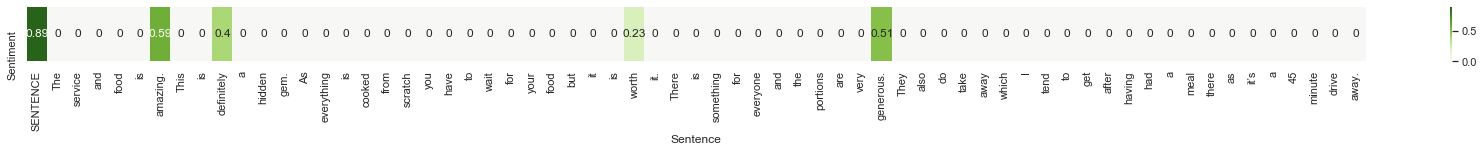

In [25]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Flair Sentiment analysis 

In [19]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

[POSITIVE (0.9613409042358398)]

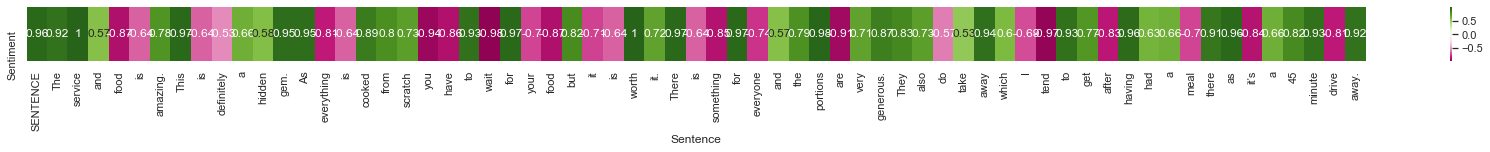

In [26]:
tokens = [token.text for token in s.tokens]
ss = [flair.data.Sentence(s) for s in tokens]
[flair_sentiment.predict(s) for s in ss]
sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]

visualise_sentiments({
      "Sentence":["SENTENCE"] + tokens,
      "Sentiment":[total_sentiment[0].score *(-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")]] + sentiments,
})

### Rating vs Sentiment score 

#### Vader

In [9]:
document['vader_score'] = document.content.map(lambda x: sid.polarity_scores(x)['compound'])

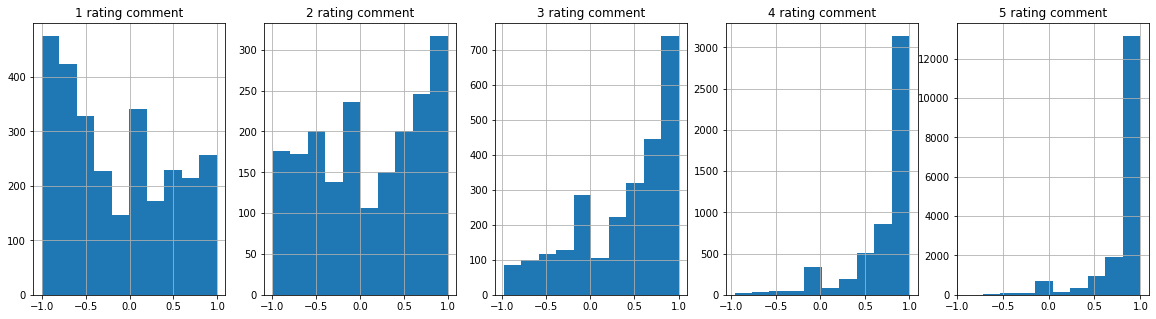

In [39]:
f = plt.figure(figsize=(20, 5))
for i in range(5):
    rating_doc = document[document['rating']==i+1]
    plt.subplot(1, 5, i+1)
    plt.title(f'{i+1} rating comment')
    rating_doc.vader_score.hist()
plt.show()